In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random
import tensorflow as tf
import tensorflow_addons as tfa 
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
print("TF version: ", tf.__version__)
print("GPU available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Keras version: ", keras.__version__)      

TF version:  2.10.0
NOT AVAILABLE
Keras version:  2.10.0


# Model with first fold

In [3]:
root_path = "data/Fold0"

os.listdir(root_path)

['test', 'train', 'valid']

In [4]:
train_dir = f"{root_path}/train"
test_dir = f"{root_path}/test"
val_dir = f"{root_path}/valid"

Class abnormal


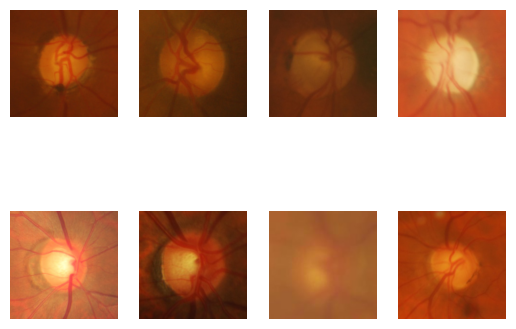

In [5]:
classes = os.listdir(train_dir)

fig = plt.figsize = (10, 5)
path = os.path.join(train_dir, classes[0])
filelist = glob.glob(path + "/*.jpg")
print(f"Class {classes[0]}")

for i in range (4):
    plt.subplot(2, 4, i+1); plt.axis('off')
    img = plt.imread(filelist[random.randint(0, len(filelist))])
    plt.imshow(img)
for i in range (4, 8):
    plt.subplot(2, 4, i+1); plt.axis('off')
    img = plt.imread(filelist[random.randint(0, len(filelist))])
    plt.imshow(img)
    
plt.show()

Class normal


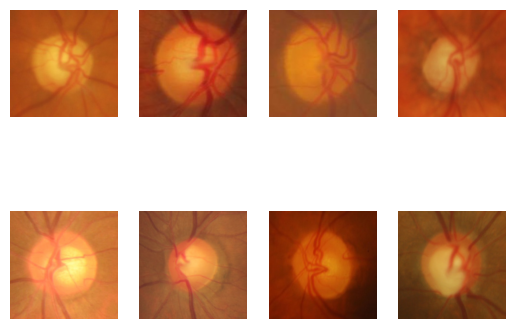

In [6]:
fig = plt.figsize = (10, 5)
path = os.path.join(train_dir, classes[0])
filelist = glob.glob(path + "/*.jpg")
print(f"Class {classes[1]}")

for i in range (4):
    plt.subplot(2, 4, i+1); plt.axis('off')
    img = plt.imread(filelist[random.randint(0, len(filelist))])
    plt.imshow(img)
for i in range (4, 8):
    plt.subplot(2, 4, i+1); plt.axis('off')
    img = plt.imread(filelist[random.randint(0, len(filelist))])
    plt.imshow(img)
    
plt.show()

### Train Test Split Fold 0

In [7]:
seed = 1234
batch_size = 32
classes = os.listdir(train_dir)
input_size = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(input_size, input_size),
    shuffle=True,
    seed=seed,
    validation_split=None,
    subset=None,
    follow_links=False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(input_size, input_size),
    shuffle=True,
    seed=seed,
    validation_split=None,
    subset=None,
    follow_links=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(input_size, input_size),
    shuffle=False,
    seed=seed,
    validation_split=None,
    subset=None,
    follow_links=False
)

Found 2758 files belonging to 2 classes.
Found 308 files belonging to 2 classes.
Found 339 files belonging to 2 classes.


In [8]:
class_name = train_ds.class_names
print(class_name)

['abnormal', 'normal']


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 1)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

### Train model with Fold 0

In [12]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

In [13]:
def build_model(num_classes):
    inputs = layers.Input(shape=(input_size, input_size, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[f1])

    return model

In [14]:
def plot_hist(hist):
    plt.plot(hist.history["f1_score"])
    plt.plot(hist.history["val_f1_score"])
    plt.title("model f1")
    plt.ylabel("f1")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    plt.show()

In [15]:
model = build_model(num_classes=len(classes))
#print(model.summary())

Epoch 1/3
87/87 [==============================] - 75s 747ms/step - loss: 0.4642 - f1_score: 0.8090 - val_loss: 0.5585 - val_f1_score: 0.7700
Epoch 2/3
87/87 [==============================] - 59s 681ms/step - loss: 0.3504 - f1_score: 0.8606 - val_loss: 0.5049 - val_f1_score: 0.7960
Epoch 3/3
87/87 [==============================] - 56s 644ms/step - loss: 0.3123 - f1_score: 0.8812 - val_loss: 0.4627 - val_f1_score: 0.8021


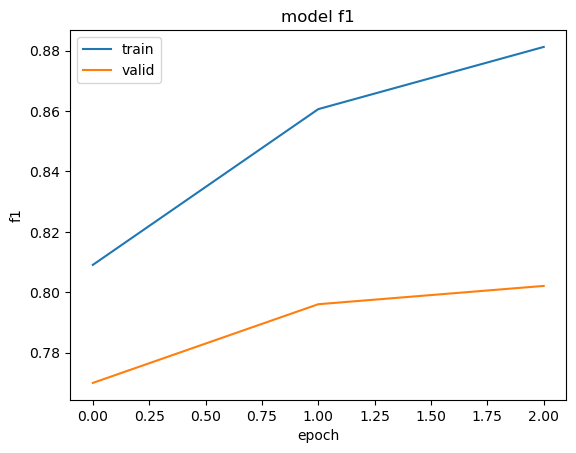

In [16]:
epochs = 3
checkpoint_best_freeze = "model_best_freeze.h5"
checkpoint_freeze = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_freeze, monitor='val_f1_score', save_weights_only=True, save_best_only=True, mode='max')
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint_freeze], verbose=1)
plot_hist(hist)

In [17]:
model.load_weights(checkpoint_best_freeze)
test_loss, test_f1 = model.evaluate(test_ds, verbose=1)
print(f"test_loss={test_loss}, test_f1={test_f1}\n")


11/11 [==============================] - 7s 655ms/step - loss: 0.4398 - f1_score: 0.8182
test_loss=0.43980205059051514, test_f1=[0.8181819]



In [23]:
pred = model.predict(test_ds)

11/11 [==============================] - 8s 568ms/step


1/1 [==============================] - 0s 363ms/step


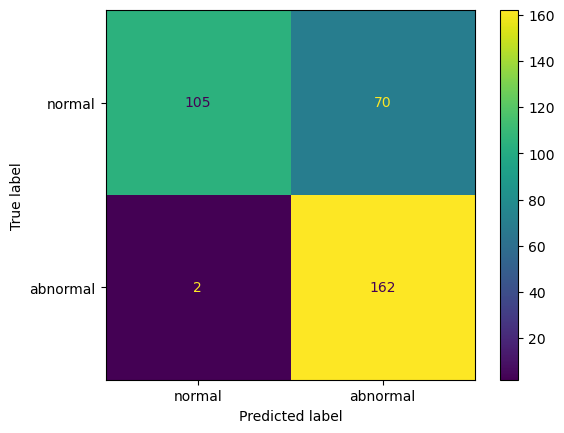

In [33]:
y_pred = []
y_true = []
threshold = 0.5

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > threshold, 1, 0))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','abnormal'])
cmd.plot()

### Unfreeze some layers

In [34]:
def unfreeze_model(model, fr=-20, lr=3e-4):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[fr:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[f1])

Epoch 1/3
87/87 [==============================] - 77s 772ms/step - loss: 0.3124 - f1_score: 0.8846 - val_loss: 0.3607 - val_f1_score: 0.8571
Epoch 2/3
87/87 [==============================] - 71s 812ms/step - loss: 0.1768 - f1_score: 0.9351 - val_loss: 0.3448 - val_f1_score: 0.8652
Epoch 3/3
87/87 [==============================] - 60s 694ms/step - loss: 0.1192 - f1_score: 0.9597 - val_loss: 0.3930 - val_f1_score: 0.8506


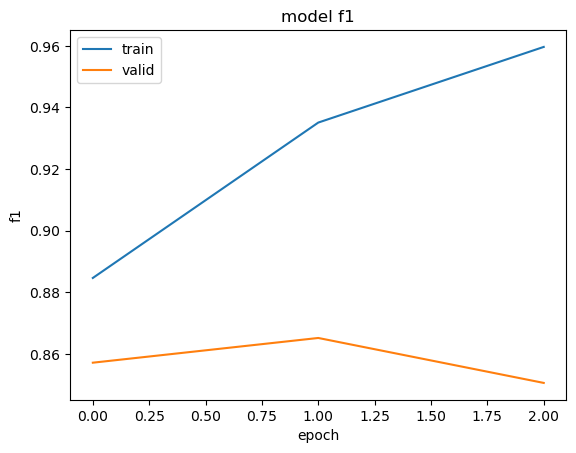

In [35]:
epochs = 3  
unfreeze_model(model, fr=-20, lr=3e-4)

checkpoint_best_first_unfreeze = "model_best_first_unfreeze.h5"
checkpoint_first_unfreeze = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_first_unfreeze, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True)

hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = [checkpoint_first_unfreeze], verbose=1)
plot_hist(hist)

In [36]:
model.load_weights(checkpoint_best_first_unfreeze)
test_loss, test_f1 = model.evaluate(test_ds, verbose=1)
print(f"test_loss={test_loss}, test_f1={test_f1}\n")

11/11 [==============================] - 7s 585ms/step - loss: 0.3710 - f1_score: 0.8478
test_loss=0.3710003197193146, test_f1=[0.84782606]



In [37]:
pred = model.predict(test_ds)

11/11 [==============================] - 8s 537ms/step


1/1 [==============================] - 2s 2s/step


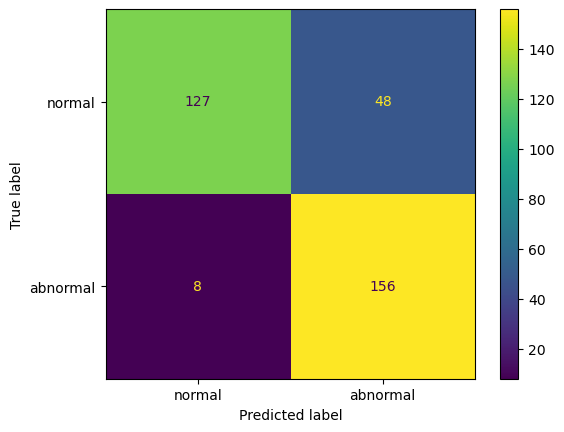

In [38]:
y_pred = []
y_true = []
threshold = 0.5

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > threshold, 1, 0))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','abnormal'])
cmd.plot()

### Unfreeze full model

Epoch 1/3
87/87 [==============================] - 225s 2s/step - loss: 0.1498 - f1_score: 0.9336 - val_loss: 0.2507 - val_f1_score: 0.9080
Epoch 2/3
87/87 [==============================] - 190s 2s/step - loss: 0.0762 - f1_score: 0.9765 - val_loss: 0.2545 - val_f1_score: 0.9186
Epoch 3/3
87/87 [==============================] - 183s 2s/step - loss: 0.0546 - f1_score: 0.9820 - val_loss: 0.6452 - val_f1_score: 0.8421


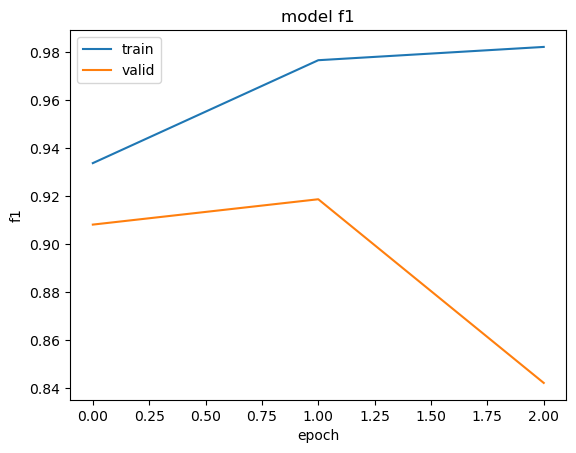

In [39]:
epochs = 3  

unfreeze_model(model, fr=0, lr=1e-4)

checkpoint_best_unfreeze_all = "model_best_unfreeze_all.h5"
checkpoint_unfreeze_all = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_unfreeze_all, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True)

hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = [checkpoint_unfreeze_all], verbose=1)
plot_hist(hist)

In [40]:
model.load_weights(checkpoint_best_unfreeze_all)
test_loss, test_f1 = model.evaluate(test_ds, verbose=1)
print(f"test_loss={test_loss}, test_f1={test_f1}\n")

11/11 [==============================] - 6s 571ms/step - loss: 0.2378 - f1_score: 0.9112
test_loss=0.23782499134540558, test_f1=[0.91124254]



1/1 [==============================] - 2s 2s/step


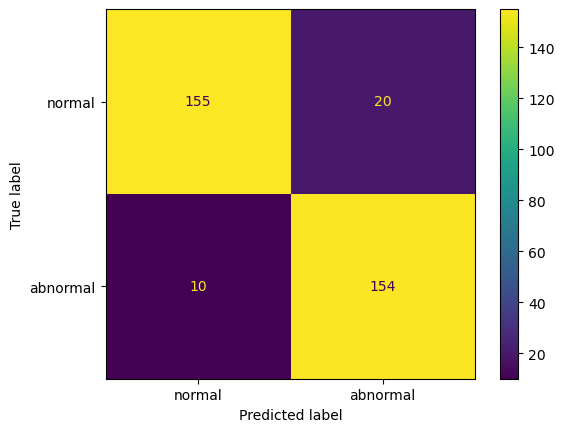

In [41]:
y_pred = []
y_true = []
threshold = 0.5

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > threshold, 1, 0))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','abnormal'])
cmd.plot()

# Other models

Epoch 1/3
87/87 [==============================] - 371s 4s/step - loss: 0.4006 - f1_score: 0.8316 - val_loss: 0.4945 - val_f1_score: 0.8058
Epoch 2/3
87/87 [==============================] - 226s 3s/step - loss: 0.2045 - f1_score: 0.9267 - val_loss: 0.4371 - val_f1_score: 0.8259
Epoch 3/3
87/87 [==============================] - 218s 2s/step - loss: 0.1088 - f1_score: 0.9647 - val_loss: 0.3558 - val_f1_score: 0.8877


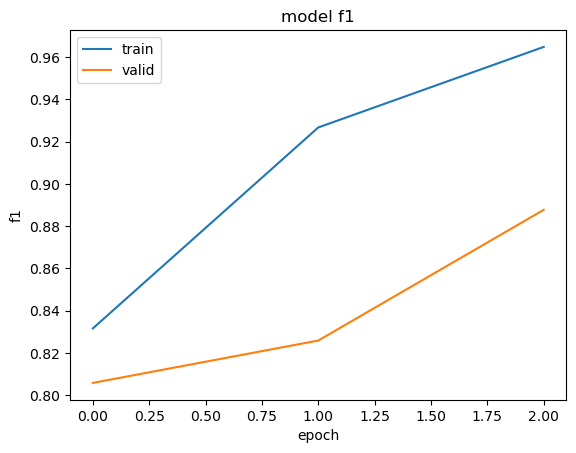

In [65]:
# resnet50V2

train_ds.batch_size = 32
val_ds.batch_size = 32
test_ds.batch_size = 32

epochs = 3

from tensorflow.keras.applications import ResNet50V2
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

def build_model_Resnet50V2(num_classes):
    inputs = layers.Input(shape=(input_size, input_size, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs,  weights='imagenet')
    
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="ResnetV2")
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[f1])

    return model

model_resnetv2 = build_model_Resnet50V2(num_classes=len(classes))
unfreeze_model(model_resnetv2, fr=0, lr=1e-4)

checkpoint_best_resnetv2 = "model_best_resnetv2.h5"
checkpoint_Resnetv2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_resnetv2, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True)

hist = model_resnetv2.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = [checkpoint_Resnetv2], verbose=1)
plot_hist(hist)

11/11 [==============================] - 6s 509ms/step - loss: 0.3796 - f1_score: 0.8571
test_loss=0.3795967996120453, test_f1=[0.85714287]

1/1 [==============================] - 0s 349ms/step


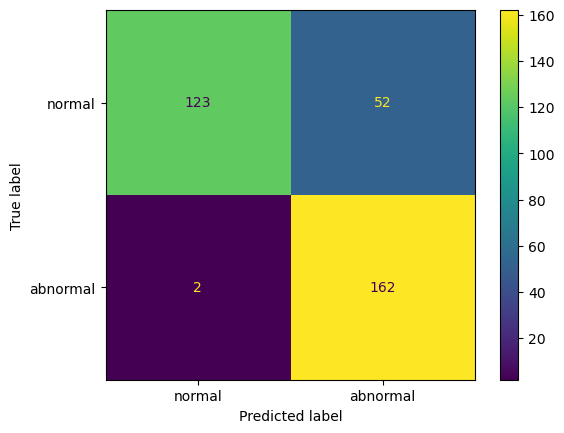

In [66]:
pred = model.predict(test_ds)

model.load_weights(checkpoint_best_resnetv2)
test_loss, test_f1 = model.evaluate(test_ds, verbose=1)
print(f"test_loss={test_loss}, test_f1={test_f1}\n")

y_pred = []
y_true = []
threshold = 0.5

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > threshold, 1, 0))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','abnormal'])
cmd.plot()

Epoch 1/3
87/87 [==============================] - 732s 8s/step - loss: 0.3915 - f1_score: 0.8421 - val_loss: 0.4260 - val_f1_score: 0.8539
Epoch 2/3
87/87 [==============================] - 680s 8s/step - loss: 0.1619 - f1_score: 0.9436 - val_loss: 0.3269 - val_f1_score: 0.8925
Epoch 3/3
87/87 [==============================] - 903s 10s/step - loss: 0.0727 - f1_score: 0.9766 - val_loss: 0.2116 - val_f1_score: 0.9266


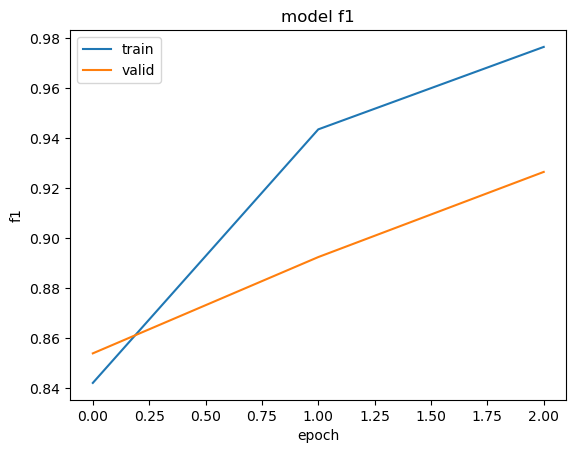

In [59]:
# EfficientNetB4

#train_ds.batch_size = 32
#val_ds.batch_size = 32
#test_ds.batch_size = 32

epochs = 3

from tensorflow.keras.applications import EfficientNetB4
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

def build_model_EfficientNetB4(num_classes):
    inputs = layers.Input(shape=(input_size, input_size, 3))
    model = EfficientNetB4(include_top=False, input_tensor=inputs,  weights='imagenet')
    
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB4")
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[f1])

    return model

model_efficientnetb4 = build_model_EfficientNetB4(num_classes=len(classes))
unfreeze_model(model_efficientnetb4, fr=0, lr=1e-4)

checkpoint_best_efficientnetb4 = "model_best_efficientnetb4.h5"
checkpoint_efficientnetb4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_best_efficientnetb4, save_weights_only=True, monitor='val_f1_score', mode='max', save_best_only=True)

hist = model_efficientnetb4.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = [checkpoint_efficientnetb4], verbose=1)
plot_hist(hist)

In [ ]:
pred = model.predict(test_ds)

model.load_weights(checkpoint_best_efficientnetb4)
test_loss, test_f1 = model.evaluate(test_ds, verbose=1)
print(f"test_loss={test_loss}, test_f1={test_f1}\n")

y_pred = []
y_true = []
threshold = 0.5

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.where(preds > threshold, 1, 0))

# convert the true and predicted labels into tensors
true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=['normal','abnormal'])
cmd.plot()